In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast
import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from utils import prepare_data, TimeMoEPredictor, chronosPredictor, LLM

/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 21:56:39,633	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-06 21:56:39,674	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Prepare data

In [3]:
train, test = prepare_data(sample_size=1000,series_cutoff=48)

/home/jan/m4_tests/utils.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))
/home/jan/m4_tests/utils.py:37: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["max"] = df.groupby("unique_id")["row"].transform(max)


In [4]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(),
    AutoETS(),
    Naive()
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality']
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

model_classes_custom = [TimeMoEPredictor(input_length=24,device="cpu"),chronosPredictor(input_length=24,device="cuda")]


Seed set to 1
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
model_wrappers = {}
model_names = []

neural = True
stats = True
ML = True
custom = True

if neural:
    for model in model_classes_neural:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            NeuralForecast( 
                models=[model],
                freq="ME"
            )
        )    

if stats:
    for model in models_classes_stats:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    

if ML:
    for model in model_classes_ml:
        model_name = str(model).split("(")[0]
        model_names.append(model_name)
        model_wrappers[model_name]=(
            MLForecast(
                models=model,
                freq='ME',
                lags=[1,2,3,4,5,6,7,8,9,10],
                lag_transforms={
                    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                },
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_name = str(type(model).__name__)
        model_names.append(model_name)
        model_wrappers[model_name] = model

In [6]:
model_wrappers

{'NBEATS': <neuralforecast.core.NeuralForecast at 0x7f5af6cb3080>,
 'DynamicOptimizedTheta': StatsForecast(models=[DynamicOptimizedTheta]),
 'AutoARIMA': StatsForecast(models=[AutoARIMA]),
 'AutoETS': StatsForecast(models=[AutoETS]),
 'Naive': StatsForecast(models=[Naive]),
 'LGBMRegressor': MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1),
 'LinearRegression': MLForecast(models=[LinearRegression], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1),
 'TimeMoEPredictor': <utils.TimeMoEPredictor at 0x7f5af6cb068

In [7]:
fit_times = []

for model_name, model in model_wrappers.items():
    if not isinstance(model, LLM):
        start = time.time()
        model.fit(df=train)
        fit_times.append(time.time()-start)
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
91        Non-trainable params
2.4 M     Total params
9.579     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 102.22it/s, v_num=34, train_loss_step=390.0, train_loss_epoch=341.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 101.27it/s, v_num=34, train_loss_step=390.0, train_loss_epoch=341.0]


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)


In [8]:
forecast_dict = {}
forecast_times = []

def add_model(forecasts,model_name):
    forecast_dict[model_name] = forecasts
    
for model_name, model in model_wrappers.items():
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        add_model(model.predict().reset_index(),model_name)
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        add_model(model.predict(h=3),model_name)
    else:
        add_model(model.predict(train,test,h=3),model_name)
        fit_times.append(0)

    forecast_times.append(time.time()-start)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 489.43it/s]
StatsForecast(models=[DynamicOptimizedTheta])


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])
StatsForecast(models=[Naive])
MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)
MLForecast(models=[LinearRegression], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/mlforecast/core.py:371: RuntimeWarning: invalid value encountered in cast
  fea

1000
3000


In [9]:
forecast_times

[0.12940192222595215,
 5.257742404937744,
 0.5072970390319824,
 0.4253101348876953,
 0.38071584701538086,
 0.007757425308227539,
 0.0046045780181884766,
 6.804974794387817,
 0.22379422187805176]

In [10]:
def _zero_to_nan(series: pd.Series) -> pd.Series:
    if isinstance(series, pd.Series):
        res = series.replace(0, np.nan)
    return res

In [60]:

def wape(
    df:  pd.DataFrame,
    models: list[str],
    id_col: str = "unique_id",
    target_col: str = "y",
    target_col2: str= "y",
) ->  pd.DataFrame:
    """Weighted Absolute Percentage Error (WAPE)

    WAPE measures the relative prediction
    accuracy of a forecasting method by calculating the percentual deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    The closer to zero an observed value is, the higher penalty WAPE loss
    assigns to the corresponding error."""
    if isinstance(df, pd.DataFrame):
        res = (
            df[models]
            .sub(df[target_col], axis=0)
            .abs()
            .groupby(df[id_col], observed=True)
            .sum()
            .div(
                 (df[models]
                .abs()
                .groupby(df[id_col], observed=True).sum()), axis=0)
            )
        res.index.name = id_col
        res = res.reset_index()

    else:

            def gen_expr(model):
                abs_err = pl.col(target_col).sub(pl.col(model)).abs()
                abs_target = _zero_to_nan(pl.col(target_col))
                ratio = abs_err.truediv(abs_target).alias(model)
                return ratio.fill_nan(None)

            res = _pl_agg_expr(df, models, id_col, gen_expr)
    return res

In [61]:
metrics = [
    mape,
    wape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [16]:
test = test.reset_index()

for name,forecast in forecast_dict.items():
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [62]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [63]:
eval[eval["metric"]=='wape']

,unique_id,metric,index,NBEATS,DynamicOptimizedTheta,AutoARIMA,AutoETS,Naive,LGBMRegressor,LinearRegression,TimeMoEPredictor,chronosPredictor
1000,M10000,wape,55.811594,0.190291,0.075334,0.132681,0.075875,0.075881,0.076597,0.091364,0.209032,0.175989
1001,M10127,wape,10.829787,0.005034,0.006670,0.005790,0.004706,0.010909,0.005705,0.017185,0.020023,0.013426
1002,M1013,wape,15.760563,0.183765,0.421654,0.430123,0.312701,0.184932,0.292334,0.299883,0.220727,0.119386
1003,M10148,wape,32.715789,0.008451,0.006562,0.008367,0.006198,0.006493,0.006835,0.006167,0.007705,0.006679
1004,M10176,wape,13.140196,0.062069,0.008163,0.068563,0.066508,0.066508,0.061576,0.051195,0.062621,0.064004
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,M9825,wape,0.940733,0.180773,0.254173,0.214118,0.274197,0.133333,0.143880,0.142089,0.065976,0.090920
1996,M983,wape,0.876569,0.032732,0.029149,0.013054,0.036268,0.036257,0.035854,0.061587,0.035509,0.016283
1997,M9922,wape,0.982882,0.068484,0.180159,0.114212,0.180002,0.180000,0.165292,0.068535,0.108199,0.171973
1998,M9942,wape,0.968717,0.129116,0.128312,0.127907,0.127911,0.127907,0.132226,0.131566,0.142813,0.119430


In [96]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).corr()

0                                        
metric        mape      mase      rmse     rmsse      wape
  metric                                                  
0 mape    1.000000  0.168985  0.408202  0.159272  0.381738
  mase    0.168985  1.000000  0.367243  0.967012  0.355841
  rmse    0.408202  0.367243  1.000000  0.395629  0.758150
  rmsse   0.159272  0.967012  0.395629  1.000000  0.365456
  wape    0.381738  0.355841  0.758150  0.365456  1.000000

In [97]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).describe()

0                                                     
metric         mape         mase          rmse        rmsse         wape
count   9000.000000  9000.000000   9000.000000  9000.000000  9000.000000
mean       0.140723     0.826166    509.195446     0.741763     0.109073
std        0.460612     1.110737   1219.371357     0.964462     0.233153
min        0.000000     0.000000      0.000000     0.000000     0.000000
25%        0.014135     0.253776     57.501810     0.240328     0.014206
50%        0.040154     0.532765    165.200919     0.493082     0.040681
75%        0.122527     0.994688    441.597282     0.900353     0.120080
max        9.022224    17.106852  19604.535992    13.808181     6.932441

In [64]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

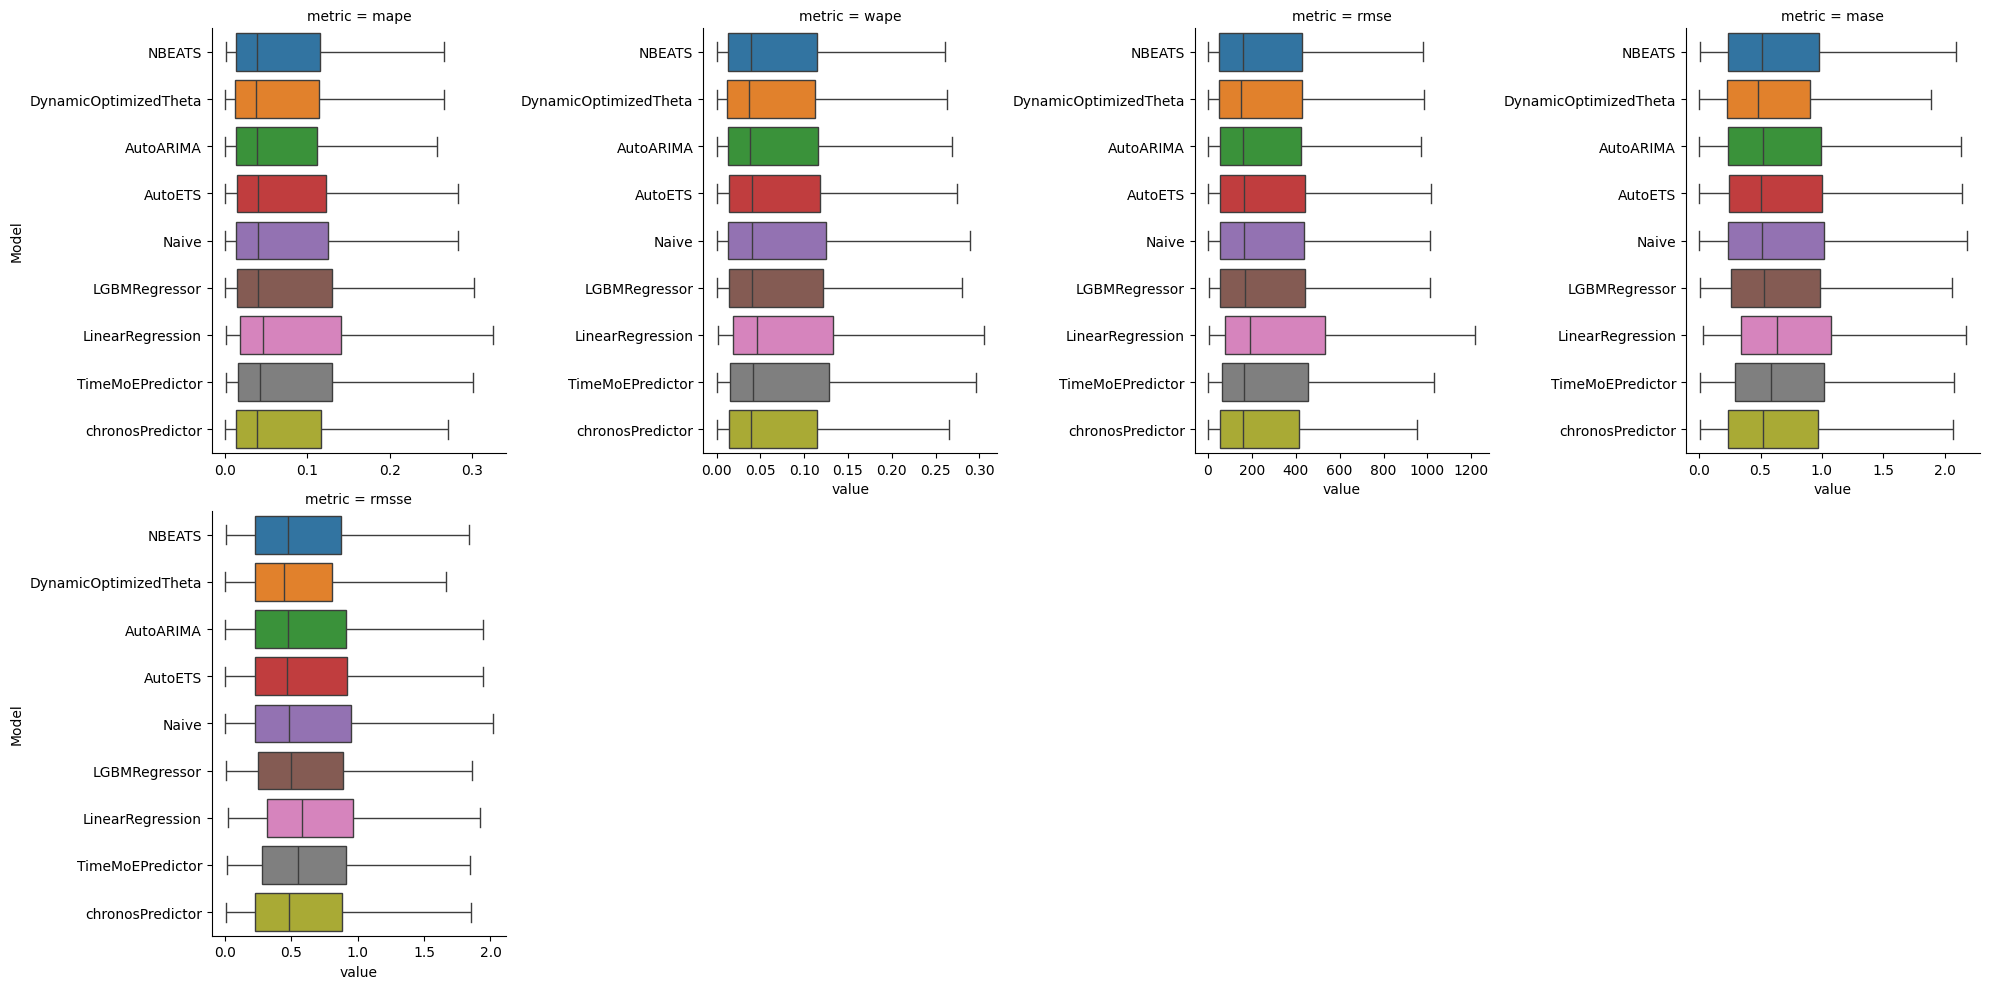

In [65]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [66]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_time":fit_times,
        "inference_time":forecast_times
    }
).set_index("Model")

In [68]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,LGBMRegressor,LinearRegression,NBEATS,Naive,TimeMoEPredictor,chronosPredictor
metric,,,,,,,,,
mape,0.038750,0.040203,0.037035,0.040328,0.046227,0.039258,0.040214,0.041788,0.039209
mase,0.516541,0.502563,0.475772,0.526787,0.631479,0.513992,0.515858,0.586735,0.521557
rmse,161.511496,164.476500,151.446931,167.656794,192.528412,160.211760,163.230922,162.940698,159.490609
rmsse,0.472190,0.464999,0.446007,0.493683,0.577190,0.476203,0.482381,0.546806,0.481659
wape,0.038760,0.040703,0.036935,0.040005,0.045945,0.038830,0.040814,0.041905,0.039826


In [69]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

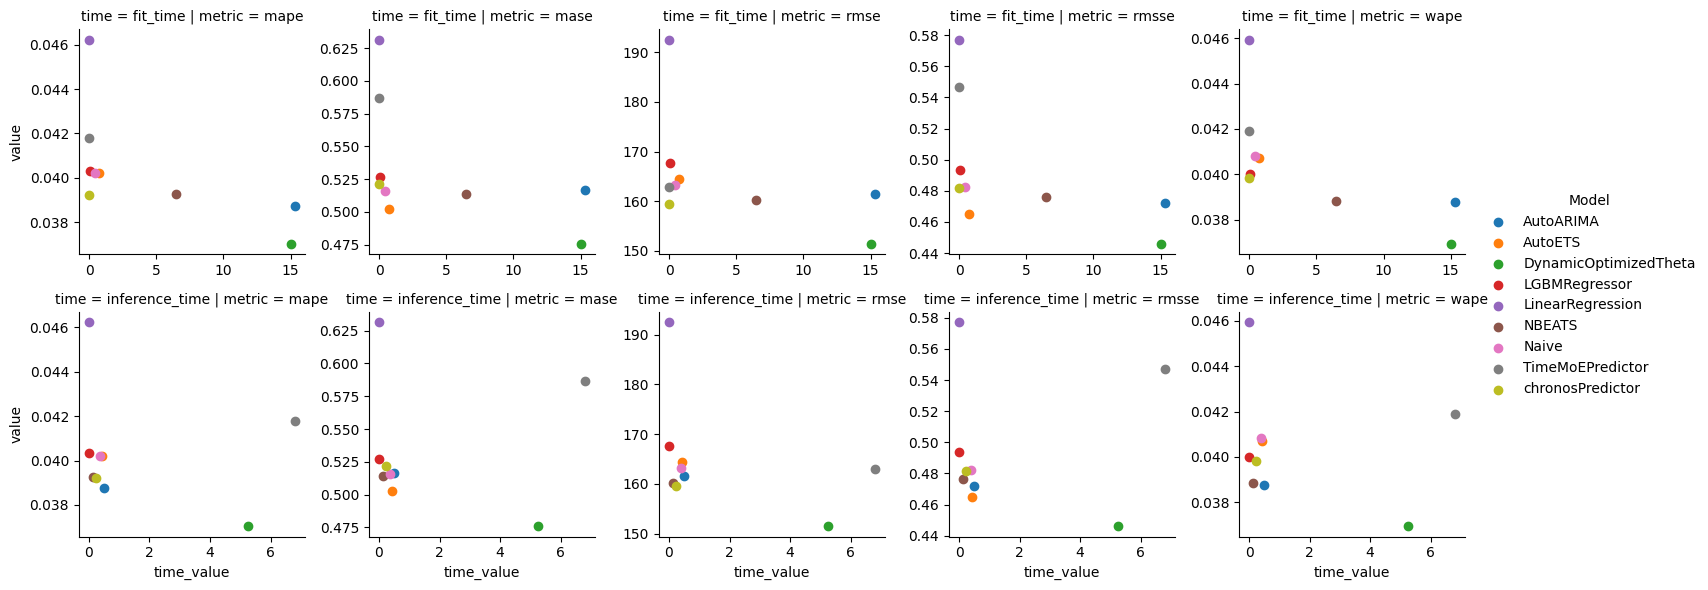

In [70]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()